<a href="https://colab.research.google.com/github/eshal26/Leukemia-classification/blob/main/ROC_and_PR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip test_dataset.zip

Archive:  test_dataset.zip
   creating: test_dataset/Benign/
  inflating: test_dataset/Benign/WBC-Benign-003.jpg  
  inflating: test_dataset/Benign/WBC-Benign-010.jpg  
  inflating: test_dataset/Benign/WBC-Benign-018.jpg  
  inflating: test_dataset/Benign/WBC-Benign-024.jpg  
  inflating: test_dataset/Benign/WBC-Benign-025.jpg  
  inflating: test_dataset/Benign/WBC-Benign-026.jpg  
  inflating: test_dataset/Benign/WBC-Benign-031.jpg  
  inflating: test_dataset/Benign/WBC-Benign-040.jpg  
  inflating: test_dataset/Benign/WBC-Benign-057.jpg  
  inflating: test_dataset/Benign/WBC-Benign-064.jpg  
  inflating: test_dataset/Benign/WBC-Benign-071.jpg  
  inflating: test_dataset/Benign/WBC-Benign-074.jpg  
  inflating: test_dataset/Benign/WBC-Benign-076.jpg  
  inflating: test_dataset/Benign/WBC-Benign-080.jpg  
  inflating: test_dataset/Benign/WBC-Benign-083.jpg  
  inflating: test_dataset/Benign/WBC-Benign-091.jpg  
  inflating: test_dataset/Benign/WBC-Benign-105.jpg  
  inflating: test_dat

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Path to your dataset in Google Drive
dataset_path = 'test_dataset'

# Load the dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Create a DataLoader
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate through the DataLoader
for images, labels in test_loader:
    print(images.size(), labels.size())
    break


torch.Size([32, 3, 299, 299]) torch.Size([32])


In [8]:
import torch
import gdown
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as tv_models  # Renamed to avoid conflict with 'models' variable

# Define device
device = torch.device('cpu')

# Step 1: Download and Load the Models

def download_and_load_model(file_id, output_name):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output_name, quiet=False)
    model = torch.load(output_name, map_location=device)  # Map the storage to the CPU
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

# Google Drive file IDs and output names for the models
model_files = [
    ('13lNnIi5LoqCqHHjbwxgz3lMwOyeXMX3Q', 'resnet50.pth'),
    ('1a989oCR3nmtQ-BOFQTXie5Xi-qY2SomD', 'resnet152.pth'),
    ('1VbfraVHTq0cBpj4ngCSp_p8XTzq2HMz0', 'alexnet.pth'),
    ('1-0wHnQer7wChHAaxA_clO6xtNGUGXuvY', 'vgg16.pth'),  # Updated VGG16 file ID
    ('1-h9W0-bQjWPrz0-j5CrIopwcPj48r3Bb', 'vgg19.pth'),
    ('1--kBBiBqS97i_liPg4i5GUvoZ306P_A_', 'googlenet.pth')
]

# Load the models
loaded_models = []
for file_id, output_name in model_files:
    model = download_and_load_model(file_id, output_name)
    loaded_models.append(model)



Downloading...
From (original): https://drive.google.com/uc?id=13lNnIi5LoqCqHHjbwxgz3lMwOyeXMX3Q
From (redirected): https://drive.google.com/uc?id=13lNnIi5LoqCqHHjbwxgz3lMwOyeXMX3Q&confirm=t&uuid=133990e4-093b-4fb6-a256-de19f4f7bc83
To: /content/resnet50.pth
100%|██████████| 94.4M/94.4M [00:00<00:00, 156MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1a989oCR3nmtQ-BOFQTXie5Xi-qY2SomD
From (redirected): https://drive.google.com/uc?id=1a989oCR3nmtQ-BOFQTXie5Xi-qY2SomD&confirm=t&uuid=f2b3243c-8a34-436a-bf42-bacf8b39452b
To: /content/resnet152.pth
100%|██████████| 234M/234M [00:06<00:00, 33.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1VbfraVHTq0cBpj4ngCSp_p8XTzq2HMz0
From (redirected): https://drive.google.com/uc?id=1VbfraVHTq0cBpj4ngCSp_p8XTzq2HMz0&confirm=t&uuid=f4ce532c-56a9-4585-8393-8af3257448e1
To: /content/alexnet.pth
100%|██████████| 228M/228M [00:06<00:00, 35.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-0wHn

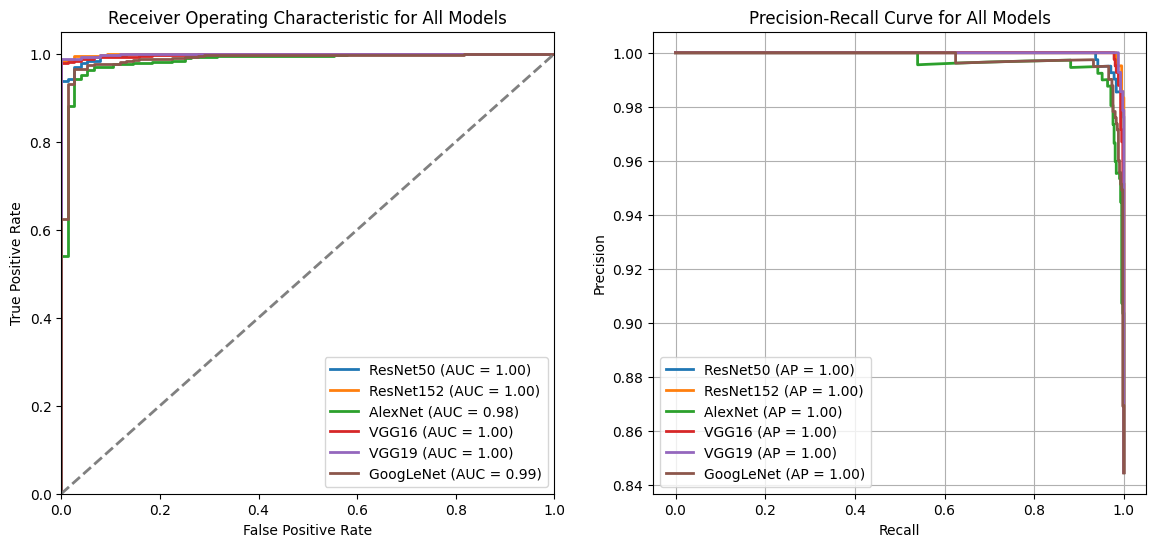

In [12]:
model_names = [
    'ResNet50',
    'ResNet152',
    'AlexNet',
    'VGG16',
    'VGG19',
    'GoogLeNet'
]
# Define the function to get model outputs
def get_model_outputs(model, test_loader, device):
    y_true, y_scores = [], []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # For binary classification, use sigmoid activation function
            if outputs.size(1) == 2:
                # If the output size is 2, use softmax to get probabilities
                probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
            else:
                # For single output (logit), use sigmoid activation function
                probabilities = torch.sigmoid(outputs).squeeze()  # Convert logits to probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    return np.array(y_true), np.array(y_scores)


# Get model outputs and calculate metrics
roc_curves = []
pr_curves = []

for model, model_name in zip(loaded_models, model_names):
    y_true, y_scores = get_model_outputs(model, test_loader, device)

    # Ensure y_true is a 1D array
    if y_true.ndim > 1:
        y_true = y_true[:, 0]

    # Compute ROC curves and AUC scores
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Compute PR curves and AUC scores
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr_score = average_precision_score(y_true, y_scores)

    # Store curves
    roc_curves.append((fpr, tpr, auc_score, model_name))
    pr_curves.append((precision, recall, auc_pr_score, model_name))

# Plot ROC Curves
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for fpr, tpr, auc_score, model_name in roc_curves:
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for All Models')
plt.legend(loc='lower right')

# Plot PR Curves
plt.subplot(1, 2, 2)
for precision, recall, auc_pr_score, model_name in pr_curves:
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {auc_pr_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Models')
plt.legend(loc='lower left')
plt.grid(True)

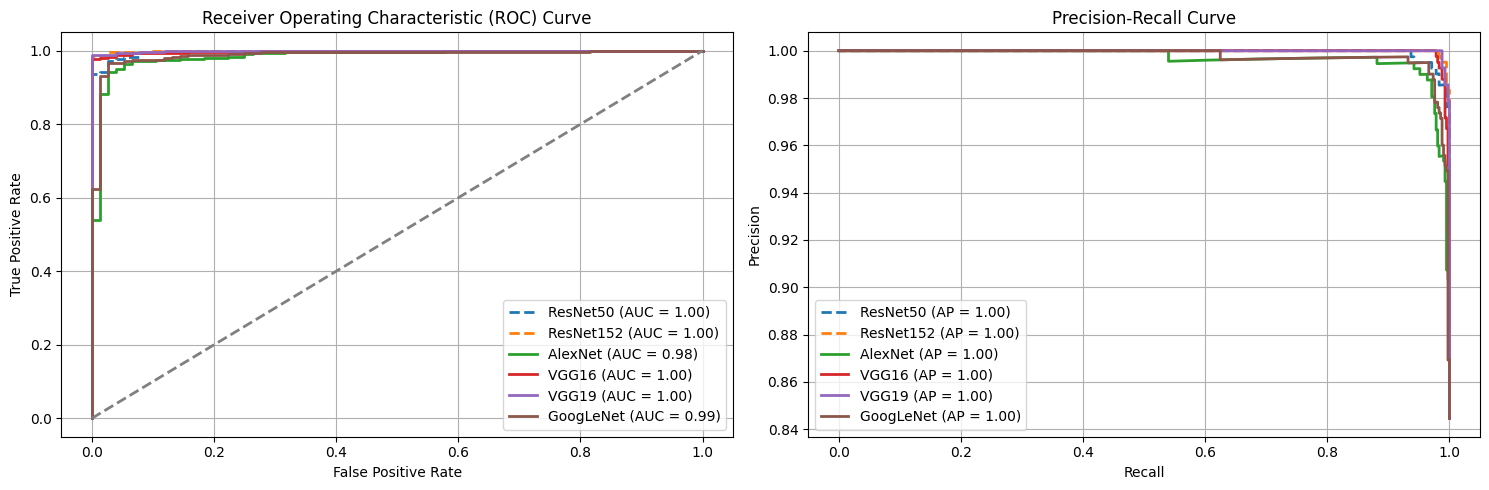

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# Plot ROC Curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for fpr, tpr, auc_score, model_name in roc_curves:
    linestyle = '--' if 'ResNet' in model_name else '-'  # Change line style based on model type
    plt.plot(fpr, tpr, lw=2, linestyle=linestyle, label=f"{model_name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()

# Plot Precision-Recall Curves
plt.subplot(1, 2, 2)
for precision, recall, auc_pr_score, model_name in pr_curves:
    linestyle = '--' if 'ResNet' in model_name else '-'  # Change line style based on model type
    plt.plot(recall, precision, lw=2, linestyle=linestyle, label=f"{model_name} (AP = {auc_pr_score:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
